##Setting up

In [ ]:
!pip install verstack

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Train Data Cleaning

In [ ]:
df = pd.read_csv("train.csv")

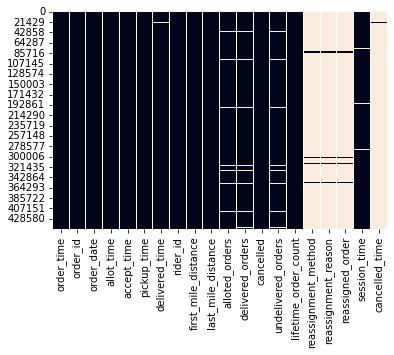

In [ ]:
sns.heatmap(df.isnull(), cbar=False)

In [ ]:
df = df.drop("cancelled_time", axis=1)

In [ ]:
df.alloted_orders = df.alloted_orders.fillna(5)
df.delivered_orders = df.delivered_orders.fillna(5)
df.undelivered_orders = df.undelivered_orders.fillna(0)
#session times, first and last mile distances, lifetime order count

In [ ]:
def encodeMethod(x):
  if(x=='auto'):
    return 1
  elif(x=='manual'):
    return 2
  else:
    return 0

In [ ]:
def encodeReason(x):
  if(x=='Reassignment Request from SE portal.'):
    return 1
  elif(x=='Auto Reassignment basis Inaction. coreengine.tasks.repush_order_to_aa_bucket'):
    return 2
  elif(x=='Reassign'):
    return 3
  else:
    return 0

In [ ]:
df.reassigned_order = df.reassigned_order.fillna(0)
df.reassignment_method = df.reassignment_method.apply(encodeMethod)
df.reassignment_reason = df.reassignment_reason.apply(encodeReason)

In [ ]:
from datetime import datetime

def toDate(x):
    if x=="Missing_data" or len(x)!=19:
      return(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S'))
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [ ]:
from verstack import NaNImputer
imputer = NaNImputer(conservative = False, n_feats = 10,            
           fix_string_nans = True, verbose = True,                
           multiprocessing_load = 3, fill_nans_in_pure_text = True,                    
           drop_empty_cols = False, drop_nan_cols_with_constant = False)
df1 = imputer.impute(df)

NaNImputer(conservative = False, n_feats = 10,            
           fix_string_nans = True, verbose = True,                
           multiprocessing_load = 3, fill_nans_in_pure_text = True,                    
           drop_empty_cols = False, drop_nan_cols_with_constant = False                        
           feature_selection = correlation)

Dataset dimensions:
 - rows:         450000
 - columns:      19
 - mb in memory: 65.23
 - NaN cols num: 5
--------------------------

Deploy multiprocessing with 2 parallel proceses

Missing values in accept_time replaced by "Missing_data" value
--------------------------------------------------
Missing values in pickup_time replaced by "Missing_data" value
--------------------------------------------------
Missing values in delivered_time replaced by "Missing_data" value
--------------------------------------------------
- lifetime_order_count:          imputed 53 NaNs
- session_time:                  imputed 3675 NaNs

NaNs imputation 

In [ ]:
df["order_time"] = df["order_time"].apply(toDate)
df["order_date"] = df["order_date"].apply(toDate)
df["allot_time"] = df["allot_time"].apply(toDate)
df["accept_time"] = df["accept_time"].apply(toDate) 
df["pickup_time"] = df["pickup_time"].apply(toDate)
df["delivered_time"] = df["delivered_time"].apply(toDate)

In [ ]:
#Time difference between order and allot time
df["T1"] = (df["allot_time"] - df["order_time"])
df["T1"] = df["T1"].apply(lambda x: x.seconds)

In [ ]:
#Time difference between order and accept time
df["T2"] = (df["accept_time"] - df["order_time"])
df["T2"] = df["T2"].apply(lambda x: x.seconds)
df['T2'] = np.where(df['accept_time']==(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')), -1, 
                    df['T2'])

In [ ]:
#Time difference between allot and accept time
df["T3"] = (df["accept_time"] - df["allot_time"])
df["T3"] = df["T3"].apply(lambda x: x.seconds)
df['T3'] = np.where(df['accept_time']==(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')), -1, 
                    df['T3'])

In [ ]:
#Time difference between pickup and delivered time
df["T4"] = (df["delivered_time"] - df["pickup_time"])
df["T4"] = df["T4"].apply(lambda x: x.seconds)
df['T4'] = np.where(df['pickup_time']==(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')), -1, 
                    df['T4'])

In [ ]:
df.order_time = df.order_time.apply(lambda x: x.hour)

## Checking Data After Cleaning

In [ ]:
df.tail()

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,T1,T2,T3,T4
449995,10,130226,2021-02-06,2021-02-06 10:03:44,2021-02-06 10:04:14,2021-02-06 10:27:29,2021-02-06 10:44:08,1006,0.5789,0.19,4.0,4.0,0,0.0,127.0,0,0,0.0,369.516667,28,58,30,999
449996,10,130227,2021-02-06,2021-02-06 10:03:18,2021-02-06 10:04:34,2021-02-06 10:22:17,2021-02-06 10:31:43,279,1.9863,1.19,81.0,81.0,0,0.0,105.0,0,0,0.0,239.133333,1,77,76,566
449997,10,130228,2021-02-06,2021-02-06 10:04:06,2021-02-06 10:04:39,2021-02-06 10:19:06,2021-02-06 10:26:56,3161,1.5944,1.61,28.0,28.0,0,0.0,1488.0,0,0,0.0,204.150000,48,81,33,470
449998,10,130229,2021-02-06,2021-02-06 10:03:19,2021-02-06 10:05:41,2021-02-06 10:20:39,2021-02-06 10:30:41,9396,2.8939,4.68,72.0,72.0,0,0.0,105.0,0,0,0.0,65.583333,0,142,142,602
449999,10,130230,2021-02-06,2021-02-06 10:03:45,2021-02-06 10:05:14,2021-02-06 10:13:26,2021-02-06 10:19:41,2078,1.8925,0.09,30.0,30.0,0,0.0,108.0,0,0,0.0,212.000000,21,110,89,375


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   order_time            450000 non-null  int64         
 1   order_id              450000 non-null  int64         
 2   order_date            450000 non-null  datetime64[ns]
 3   allot_time            450000 non-null  datetime64[ns]
 4   accept_time           450000 non-null  datetime64[ns]
 5   pickup_time           450000 non-null  datetime64[ns]
 6   delivered_time        450000 non-null  datetime64[ns]
 7   rider_id              450000 non-null  int64         
 8   first_mile_distance   450000 non-null  float64       
 9   last_mile_distance    450000 non-null  float64       
 10  alloted_orders        450000 non-null  float64       
 11  delivered_orders      450000 non-null  float64       
 12  cancelled             450000 non-null  int64         
 13 

## Train Feature Selection

In [ ]:
df1 = df

In [ ]:
df1 = df1.drop("order_date", axis=1)
df1 = df1.drop("accept_time", axis=1)
df1 = df1.drop("allot_time", axis=1)
df1 = df1.drop("pickup_time", axis=1)
df1 = df1.drop("delivered_time", axis=1)
df1 = df1.drop("order_time", axis=1)
df1 = df1.drop("session_time", axis=1)
#df1 = df1.drop("lifetime_order_count", axis=1)
df1 = df1.drop("reassignment_method", axis=1)
#df1 = df1.drop("reassignment_reason", axis=1)
df1 = df1.drop("reassigned_order", axis=1)
#df1 = df1.drop("first_mile_distance", axis=1)
#df1 = df1.drop("last_mile_distance", axis=1)
df1 = df1.drop("T4", axis=1) # Or use regression model to generate T4 for test data

In [ ]:
df1

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_reason,T1,T2,T3
0,556753,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,0,24,33,9
1,556754,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,0,41,89,48
2,556755,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,0,8,24,16
3,556756,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,0,32,73,41
4,556757,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,0,51,87,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
449995,130226,1006,0.5789,0.19,4.0,4.0,0,0.0,127.0,0,28,58,30
449996,130227,279,1.9863,1.19,81.0,81.0,0,0.0,105.0,0,1,77,76
449997,130228,3161,1.5944,1.61,28.0,28.0,0,0.0,1488.0,0,48,81,33
449998,130229,9396,2.8939,4.68,72.0,72.0,0,0.0,105.0,0,0,142,142


## Model

In [ ]:
!pip install XGBOOST

In [ ]:
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
X = df1.drop("cancelled", axis=1)
Y = df1['cancelled']

In [ ]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [ ]:
#from xgboost import XGBClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

## Model Training and Metrics

In [ ]:
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
y_pred_p = model.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_p)
print("AUC Score:",auc)
print("F1 Score:",f1_score(y_test, y_pred))


Accuracy: 95.87%
AUC Score: 0.7047217866700546
F1 Score: 0.08339560603796144


In [ ]:
cm=confusion_matrix(y_pred, y_test)
cm

array([[142088,   1419],
       [  4714,    279]])

## Test Data Cleaning

In [ ]:
df_test = pd.read_csv("test.csv")

In [ ]:
df_test.shape

(144844, 16)

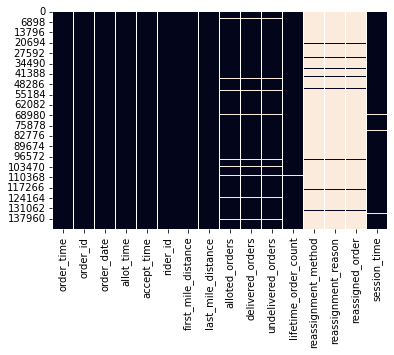

In [ ]:
sns.heatmap(df_test.isnull(), cbar=False)

In [ ]:
df_test.alloted_orders = df_test.alloted_orders.fillna(5)
df_test.delivered_orders = df_test.delivered_orders.fillna(5)
df_test.undelivered_orders = df_test.undelivered_orders.fillna(0)
#session times, first and last mile distances, lifetime order count

In [ ]:
df_test.reassigned_order = df_test.reassigned_order.fillna(0)
df_test.reassignment_method = df_test.reassignment_method.apply(encodeMethod)
df_test.reassignment_reason = df_test.reassignment_reason.apply(encodeReason)

In [ ]:
from verstack import NaNImputer
imputer = NaNImputer(conservative = False, n_feats = 10,            
           fix_string_nans = True, verbose = True,                
           multiprocessing_load = 3, fill_nans_in_pure_text = True,                    
           drop_empty_cols = False, drop_nan_cols_with_constant = False)
df0 = imputer.impute(df_test)

NaNImputer(conservative = False, n_feats = 10,            
           fix_string_nans = True, verbose = True,                
           multiprocessing_load = 3, fill_nans_in_pure_text = True,                    
           drop_empty_cols = False, drop_nan_cols_with_constant = False                        
           feature_selection = correlation)

Dataset dimensions:
 - rows:         144844
 - columns:      16
 - mb in memory: 17.68
 - NaN cols num: 3
--------------------------

Deploy multiprocessing with 2 parallel proceses

Missing values in accept_time replaced by "Missing_data" value
--------------------------------------------------
- session_time:                  imputed 5054 NaNs
- lifetime_order_count:          imputed 778 NaNs

NaNs imputation time: 0.08 minutes
--------------------------------------------------


In [ ]:
df_test["order_time"] = df_test["order_time"].apply(toDate)
df_test["order_date"] = df_test["order_date"].apply(toDate)
df_test["allot_time"] = df_test["allot_time"].apply(toDate)
df_test["accept_time"] = df_test["accept_time"].apply(toDate)

In [ ]:
#Time difference between order and allot time
df_test["T1"] = (df_test["allot_time"] - df_test["order_time"])
df_test["T1"] = df_test["T1"].apply(lambda x: x.seconds)

In [ ]:
#Time difference between order and accept time
df_test["T2"] = (df_test["accept_time"] - df_test["order_time"])
df_test["T2"] = df_test["T2"].apply(lambda x: x.seconds)
df_test['T2'] = np.where(df_test['accept_time']==(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')), -1, 
                    df_test['T2'])

In [ ]:
#Time difference between allot and accept time
df_test["T3"] = (df_test["accept_time"] - df_test["allot_time"])
df_test["T3"] = df_test["T3"].apply(lambda x: x.seconds)
df_test['T3'] = np.where(df_test['accept_time']==(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')), -1, 
                    df_test['T3'])

In [ ]:
df_test.order_time = df_test.order_time.apply(lambda x: x.hour)

## Test Feature Selection

In [ ]:
df5 = df_test

In [ ]:
df5 = df5.drop("order_date", axis=1)
df5 = df5.drop("accept_time", axis=1)
df5 = df5.drop("allot_time", axis=1)
df5 = df5.drop("order_time", axis=1)
df5 = df5.drop("session_time", axis=1)
#df5 = df5.drop("lifetime_order_count", axis=1)
df5 = df5.drop("reassigned_order", axis=1)
df5 = df5.drop("reassignment_method", axis=1)
#df5 = df5.drop("reassignment_reason", axis=1)
#df5 = df5.drop("first_mile_distance", axis=1)
#df5 = df5.drop("last_mile_distance", axis=1)

In [ ]:
df5

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_reason,T1,T2,T3
0,130231,12884,1.658500,4.54,216.0,215.0,1.0,747.0,0,25,51,26
1,130232,3541,2.070900,5.84,52.0,52.0,0.0,75.0,0,1,10,9
2,130233,603,1.388400,0.99,289.0,289.0,0.0,2214.0,0,47,127,80
3,130234,3414,1.903900,2.59,125.0,122.0,3.0,1020.0,0,1,24,23
4,130235,1426,0.827500,0.94,352.0,350.0,2.0,7284.0,0,8,68,60
...,...,...,...,...,...,...,...,...,...,...,...,...
144839,41184,7141,1.417000,3.96,52.0,52.0,0.0,413.0,0,1,10,9
144840,41185,8113,0.775600,1.61,95.0,93.0,2.0,284.0,0,23,57,34
144841,41186,5040,2.049400,1.26,77.0,77.0,0.0,119.0,0,38,105,67
144842,41187,2946,0.080494,5.50,231.0,228.0,3.0,1759.0,0,22,46,24


# Predictions

In [ ]:
Y = df5

In [ ]:
# make predictions for test data
y_pred = model.predict(Y)
predictions = [round(value) for value in y_pred]
print(y_pred)

[0 0 0 ... 0 0 0]


In [ ]:
frame = { 'order_id': df5['order_id'], 'cancelled': y_pred}
result = pd.DataFrame(frame)
result.head(5)

,order_id,cancelled
0,130231,0
1,130232,0
2,130233,0
3,130234,0
4,130235,0


In [ ]:
result.to_csv("submission.csv")

In [ ]:
result[result.cancelled==1].shape[0]

5052

# Correlations

In [ ]:
df.corr()

,order_time,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,T1,T2,T3,T4
order_time,1.000000,0.134002,0.074115,-0.040278,-0.015927,-0.038901,-0.039011,0.008448,-0.009280,-0.052661,0.004037,0.005401,0.000790,0.386059,0.001544,-0.003783,-0.004219,-0.021242
order_id,0.134002,1.000000,0.159641,-0.009692,0.013014,-0.011356,-0.011430,0.004266,0.000966,0.004141,0.002658,0.000369,0.001970,0.066488,0.000506,0.004668,0.001821,0.001968
rider_id,0.074115,0.159641,1.000000,0.001891,-0.003347,-0.292889,-0.292881,0.058096,-0.134905,-0.143162,0.009945,0.007934,0.009953,-0.174008,0.010949,0.023069,0.006147,0.058712
first_mile_distance,-0.040278,-0.009692,0.001891,1.000000,0.130759,0.007015,0.006888,0.009679,0.014083,0.023070,0.077153,0.063648,0.074373,0.008340,0.078746,0.067982,-0.000733,-0.002443
last_mile_distance,-0.015927,0.013014,-0.003347,0.130759,1.000000,0.052384,0.052334,0.018696,0.028769,-0.023204,-0.002284,-0.008754,-0.004018,-0.010620,-0.003273,-0.023277,-0.009384,0.095415
alloted_orders,-0.038901,-0.011356,-0.292889,0.007015,0.052384,1.000000,0.999946,-0.041920,0.472478,0.199044,-0.014658,-0.011406,-0.015390,0.178633,-0.019180,-0.044494,-0.012745,-0.049483
delivered_orders,-0.039011,-0.011430,-0.292881,0.006888,0.052334,0.999946,1.000000,-0.041962,0.463325,0.198724,-0.014743,-0.011489,-0.015474,0.178447,-0.019296,-0.044642,-0.012752,-0.049532
cancelled,0.008448,0.004266,0.058096,0.009679,0.018696,-0.041920,-0.041962,1.000000,-0.003101,-0.016677,0.068434,0.078321,0.067837,-0.022178,0.147616,0.135590,0.067183,0.610035
undelivered_orders,-0.009280,0.000966,-0.134905,0.014083,0.028769,0.472478,0.463325,-0.003101,1.000000,0.119733,0.000539,0.001842,0.000103,0.098043,0.001120,-0.007826,-0.005374,-0.006042
lifetime_order_count,-0.052661,0.004141,-0.143162,0.023070,-0.023204,0.199044,0.198724,-0.016677,0.119733,1.000000,0.012290,0.009238,0.012803,0.160122,0.018899,0.007604,-0.001326,-0.025862
